### Loading required liabraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import seaborn as sns
import datetime
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import scipy.stats as scipy
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from statsmodels.tools.eval_measures import rmse



### Loading and creating DataFrame

In [2]:
df = pd.read_csv('data/salary.csv')
df.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
0,53000.0,0,0,0,1.17,1,0,1,1,3,0
1,58000.0,1,0,0,1.24,1,0,1,1,2,0
2,45500.0,0,0,0,1.21,1,0,1,1,3,2
3,35782.0,0,2,1,0.99,1,0,1,1,4,1
4,34731.0,0,2,2,0.91,1,0,1,1,4,1


In [3]:
null_values= df.isnull().sum().sum()
print('Number of missing values is: ',null_values)
null = df[df.salary.isnull()]
null

Number of missing values is:  1


,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,position,male,Field,yearsabs
208,NaN,0,21,10,0.93,1,0,3,1,4,1


### Filling null value with the mean

In [4]:
df['salary'].fillna(df['salary'].mean(),inplace = True)
df = df.drop_duplicates()



### 1. Splitting the data set to training and testing

In [5]:

train_x, test_x, train_y, test_y = train_test_split(df, df.salary, test_size=0.3, random_state=50)
print(train_x.shape, train_y.shape) 
print( test_x.shape, test_y.shape)


(359, 11) (359,)
(155, 11) (155,)


 - We decided to split my dataset in a 70:30 ratio for taining:testing respectively, since given the size of the dataset, this is the most appropriate ratio to use.


# Hypothesis Testing¶
- Null Hypothesis: There is no relationship that exists between salary and all the features in the dataset.
- Alternate Hypothesis: There exists a linear relationship between salary and some of the features in the dataset.


### Looking at feautures that are highly correlated with salary

In [6]:
data_corr =train_x.corr().iloc[:,0].sort_values()
data_corr

Field         -0.475643
yearsabs      -0.048015
degree         0.054808
exprior        0.144664
otherqual      0.203106
male           0.345037
market         0.398649
yearsworked    0.609122
yearsrank      0.609984
position       0.713789
salary         1.000000
Name: salary, dtype: float64

- From this I can see that position is highly correlated with salary 
- There is a  correlation betwwen salary and years ranked.
- There is a  correlation betwwen salary and years worked.
- There is also a slight negetive correlation between salary and Field

### Validating the effect of the correlation of the above features
- with significance test using p-value

In [7]:
print(f'pvalue of years worked and salary: {stats.pearsonr(df.yearsworked, df.salary)}')
print(f'pvalue of years rank and salary: {stats.pearsonr(df.yearsrank, df.salary)}')
print(f'pvalue of postion and salary: {stats.pearsonr(df.position, df.salary)}')
print(f'pvalue of field and salary: {stats.pearsonr(df.Field, df.salary)}')

pvalue of years worked and salary: (0.6231354820920552, 1.2747795189693407e-56)
pvalue of years rank and salary: (0.610580392524893, 7.841461421302136e-54)
pvalue of postion and salary: (0.7013536954022151, 2.6542174506471035e-77)
pvalue of field and salary: (-0.49848547458371756, 1.2205378378494786e-33)


- The p-value for yearsranked is far less than 0.05, and so we believe that there is a relationship between years ranked and salary. Thus an increase in number of years worked  in your current possition will result in an increase in salary.
- The p-value for yearsworked is far less than 0.05, and so we believe that there is a relationship between years worked and salary. Thus an increase in number of years worked will result in an increase in salary.
- The p-value for position is far less than 0.05, and so we believe that there is a relationship between position and salary. Thus the higher the position,the higher the  salary.
- The p-value for field is far less than 0.05, and so we believe that there is a relationship between field and salary. Thus certain field rank higher than other position so hihg ranked field earn more.

### According to the p-values computed above which are within the threshold for all four variables, we reject the null hypothesis and go on to use years ranked,salary, position, field and years worked as key features to build my model.

## Checking for descriptive statistics table

In [8]:
df_new = train_x[['salary','yearsworked', 'yearsrank','position','Field']]


In [9]:
df_new.describe()

,salary,yearsworked,yearsrank,position,Field
count,359.000000,359.000000,359.000000,359.000000,359.000000
mean,51065.994712,12.802228,6.949861,2.150418,2.545961
std,12549.798910,9.339194,6.402927,0.811711,1.124873
min,29000.000000,0.000000,0.000000,1.000000,1.000000
25%,40625.500000,4.000000,2.000000,1.000000,2.000000
50%,50729.000000,12.000000,5.000000,2.000000,3.000000
75%,60373.500000,22.000000,11.000000,3.000000,4.000000
max,96156.000000,31.000000,24.000000,3.000000,4.000000


### Creating Histograms for the variables of interest

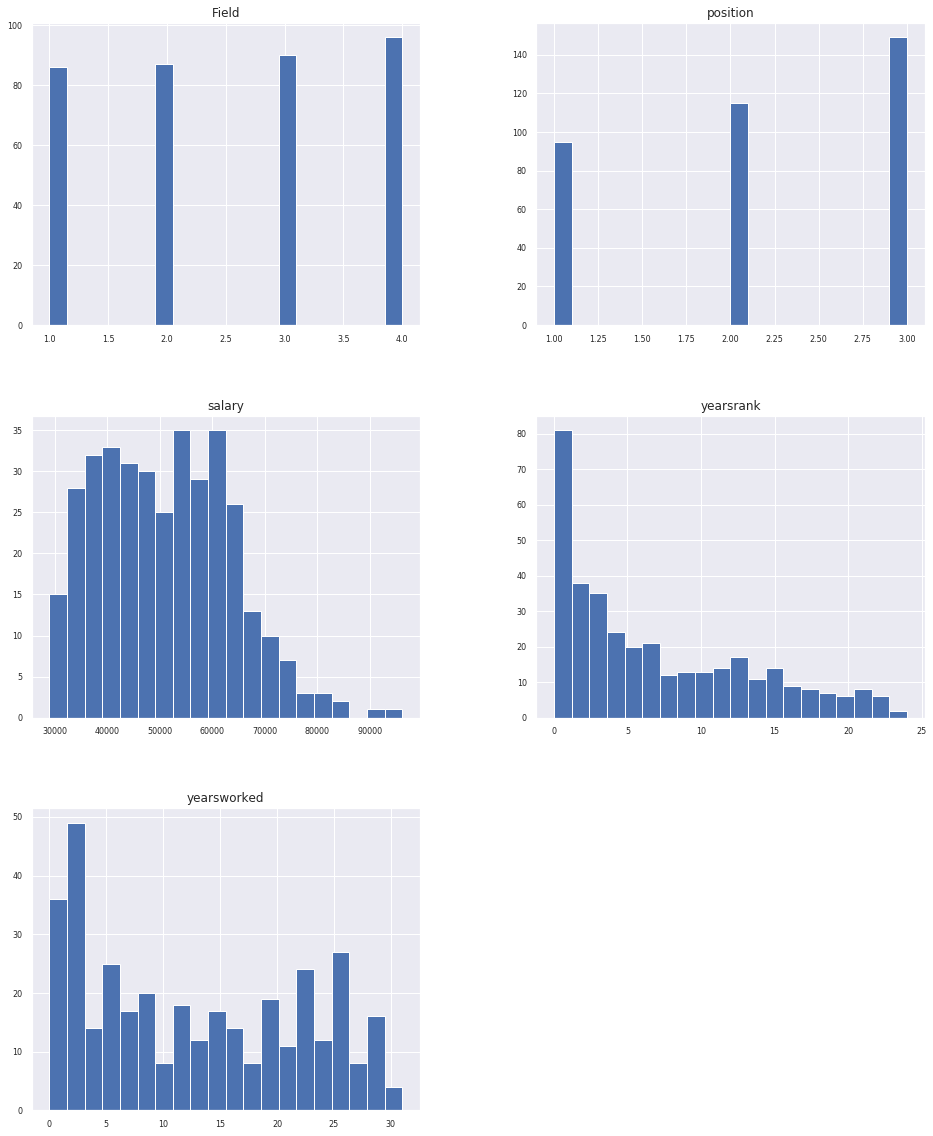

In [10]:
sns.set()
df_new.hist(figsize=(16, 20),bins=20, xlabelsize=8, ylabelsize=8);

## From the above histograms of the features of interest it is clear that Position and Field are categorical data.

 ### Salary
- There are few possible outliers
- The distribution is skewed to the right
- A lot of individuals earn between 33000 dollars & 75000 dollars
### Years worked in this field
- There are possible outliers 
- The distribution is skewed to the right
- A lot of individuals have worked between 0 years & 29 years
### Years worked at current rank
- The distribution is skewed to the right
- There are possible outliers just few of them
- Most individuals have worked at the current rank for years between 0 & 5 years.

### 2.One-hot encode the variable Field into four dummy variables, using HR as the reference category.

In [11]:
field = pd.get_dummies(df['Field'])
position = pd.get_dummies(df['position'])

new_field = field.rename(columns={1:'Engeneering',2:'Finance',3:'HR',4:'Marketing'})
new_position = position.rename(columns={1:'Junior_Employee', 2: 'Manager', 3:'Executive'})

salary = pd.concat([df, new_field, new_position] ,axis=1)
salary.drop(['position','Field'], axis=1,inplace=True)
salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,male,yearsabs,Engeneering,Finance,HR,Marketing,Junior_Employee,Manager,Executive
0,53000.0,0,0,0,1.17,1,0,1,0,0,0,1,0,1,0,0
1,58000.0,1,0,0,1.24,1,0,1,0,0,1,0,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,2,0,0,1,0,1,0,0
3,35782.0,0,2,1,0.99,1,0,1,1,0,0,0,1,1,0,0
4,34731.0,0,2,2,0.91,1,0,1,1,0,0,0,1,1,0,0


### 3.Checking for Multicolinearity

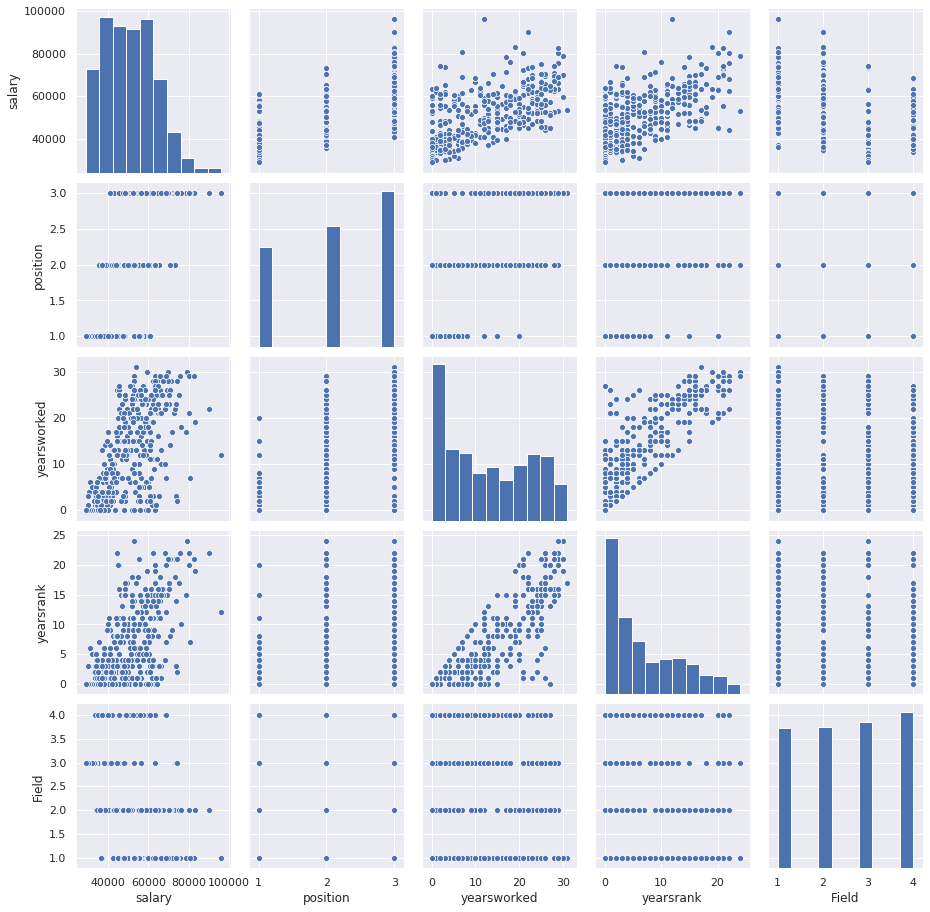

In [12]:
sns.pairplot(df_new[['salary', 'position','yearsworked','yearsrank','Field']])

- After oberving the above charts, there seem to be a linear relationship among yearsworked and years rank, thus there is multicolinearity, Therefore we are selecting one variables with the most correlation between those two as our predictors for the target salary. We will also be selecting position and field as predictors also.

## 4.Model development

### Fitting the model for the desired features

In [13]:
X = sm.add_constant(train_x[['yearsworked','position','Field']])
model = sm.OLS(train_y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     177.9
Date:                Sun, 19 Apr 2020   Prob (F-statistic):           2.09e-70
Time:                        16:45:55   Log-Likelihood:                -3732.2
No. Observations:                 359   AIC:                             7472.
Df Residuals:                     355   BIC:                             7488.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.954e+04   1815.303     21.782      0.000     3.6e+04    4.31e+04
yearsworked   218.5157     67.081      3.257      0.001      86.590     350.442
position     7881.6462    782.832     10.068      0.000    6342.074    9421.218
Field       -3228.8957    391.209     -8.254      0.000   -3998.274   -2459.518
==============================================================================
Omnibus:                       52.840   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.772
Skew:                           0.942   Prob(JB):                     1.29e-17
Kurtosis:                       4.285   Cond. No.                         73.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- According to the model above:
- 62.6% of the variation in salary is due to years worked,field and position, the Dublin-Watson score of 1.830 indicates no autocorrelation among the key features

In [14]:
model.params

const          39540.316833
yearsworked      218.515711
position        7881.646170
Field          -3228.895726
dtype: float64

### 5.Compute the standardised residuals (resid()) and standardised predicted values (fittedvalues()).¶


In [15]:
#Create residuals
residual  = model.resid

#Fit linear model to dataset
results   = model.fittedvalues


#create instance of influence
influence = model.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values and p-values
cooks_d = influence.cooks_distance

#standardized residuals(internal)
standardized_residuals = influence.resid_studentized_internal

#standardized residuals(external)
studentized_residuals = influence.resid_studentized_external

In [16]:

#Representing residuals and fitted values in a table

residuals_fitted = {'Residual': residual, 'Standard_residual':studentized_residuals, 'Predicted Salary': results, 'Actual Salary' :train_y}


residuals_fitted = pd.DataFrame(residuals_fitted)

residuals_fitted.head()

,Residual,Standard_residual,Predicted Salary,Actual Salary
347,709.611907,0.089387,62627.388093,63337.00000
3,838.588478,0.105713,34943.411522,35782.00000
210,249.408108,0.031417,64545.189552,64794.59766
35,-7193.067277,-0.911565,44193.067277,37000.00000
472,-10314.395862,-1.298663,48676.141952,38361.74609


###  6.Plot of residuals versus the predicted values  with fitted values as the x parameter, and the dependent variable as y, specifying lowess=True

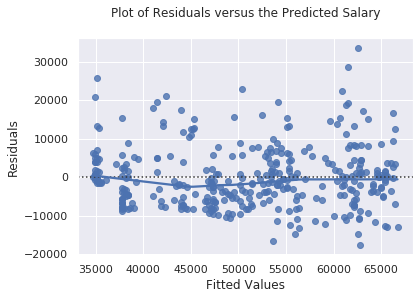

In [17]:
sns.residplot(x = results, y = residual, lowess=True)

plt.title('Plot of Residuals versus the Predicted Salary\n')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals');

Data points are pretty symmetrically distributed, tending to cluster towards the middle of the plot and they’re clustered around y = 0 showing no patterns

###  Predictions

In [18]:
#Run model on the test set
test_x = sm.add_constant(test_x[['yearsworked','position','Field']])

y_prediction = model.predict(test_x)

pred = model.predict(X)

### Model quality check

In [19]:
# Train
training_rmse = rmse(train_y, pred)
training_rmse
# Test
testing_rmse = rmse(test_y, y_prediction)
testing_rmse
diffrence  = testing_rmse - training_rmse
print(f'The difference between train and test: {diffrence}')


The difference between train and test: 207.1483807065797



#### The RMSE scores show no signs of overfitting or underfitting. The test is higer than the train values which makes sense since it has less data than the training set.The model seems to be a good model since it has satisfied the linear regression assumption.

###### Linear regression assumptions:
- Linear relationship
- Multivariate normality
- No multicollinearity
- No auto-correlation


### conclusion


- The accuracy of the model has proved that Years Worked and Position are strong predictors for employee's salary

### OPP for DATA


#### ErrorCalculator Class

In [20]:
class ErrorCalculator:

    def __init__(self, y, y_predict):

        self.y          =   np.array(y)       
        self.y_predict     =   np.array(y_predict)  


    def get_residuals(self):

        residuals = self.y - self.y_predict
        return residuals

    def get_standardised_residuals(self):

        standardised_residuals = self.get_residuals() / (self.get_residuals()/std())
        return standardised_residuals

    def get_mse(self):

        mse = np.square(np.subtract(self.y, self.y_predict)).mean()
        return mse

    def get_rmse(self):

        rmse = np.sqrt(((self.y_predict - self.y)**2).mean())
        return rmse

    def error_summary(self):
        std_resid_min = min(self.std_res)
        std_resid_max = max(self.std_res)
        rmse_min = min(self.rmse)
        rmse_max = max(self.rmse)
        mse_min = min(self.mse)
        mse_max = max(self.mse)
        print(f'standard residual: {std_resid_min}')
        print(f'standard residual: {std_resid_max}')
        print(f'min rmse: {rmse_min}')

In [21]:
class Plotter():
    def __init__(self,y_test,ypred):
        self.y_test = y_test
        self.ypred = ypred
    
    def run_calculations(self):
        return self.y_test - self.ypred
    
    def plot(self):
        plt.hist(self.y_test - self.ypred)
        plt.title('Residuals Plot for predictions')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        return plt.show()

In [22]:
class HistogramPlotter(Plotter):
    def __init__(self, y_test,ypred):
        Plotter.__init__(self, y_test, ypred)
        
class ScatterPlotter(Plotter):
    def __init__(self, y_test, ypred):
        Plotter.__init__(self, y_test, ypred)

    def plot(self):
        chart = pd.DataFrame({"y_test": self.y_test, "y_prediction": self.ypred})
        chart.plot.scatter(x="y_test", y="y_prediction", c="DarkBlue")
        plt.title("Prediction vs Actual values")
        plt.xlabel("Actual")
        plt.ylabel("Prediction")
        return plt.show()

In [23]:
salary.head()

,salary,exprior,yearsworked,yearsrank,market,degree,otherqual,male,yearsabs,Engeneering,Finance,HR,Marketing,Junior_Employee,Manager,Executive
0,53000.0,0,0,0,1.17,1,0,1,0,0,0,1,0,1,0,0
1,58000.0,1,0,0,1.24,1,0,1,0,0,1,0,0,1,0,0
2,45500.0,0,0,0,1.21,1,0,1,2,0,0,1,0,1,0,0
3,35782.0,0,2,1,0.99,1,0,1,1,0,0,0,1,1,0,0
4,34731.0,0,2,2,0.91,1,0,1,1,0,0,0,1,1,0,0


In [34]:
df= salary .drop(['Marketing'], axis = 1)

In [25]:
# Splitting the data for model 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(
   salary.drop(labels=["salary"], axis=1),
    salary["salary"],
    test_size = 0.3,
    random_state = 50)

In [26]:
# Building Model 1
model1 = sm.add_constant(X_train1)
model1 = sm.OLS(y_train1, model1).fit()
model1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     121.1
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          7.47e-120
Time:                        16:45:56   Log-Likelihood:                -3586.5
No. Observations:                 359   AIC:                             7201.
Df Residuals:                     345   BIC:                             7255.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.151e+04   1816.577      6.338      0.000    7940.475    1.51e+04
exprior           154.5185     82.017      1.884      0.060      -6.798     315.835
yearsworked      -131.7656     96.473     -1.366      0.173    -321.514      57.983
yearsrank         781.5750     89.407      8.742      0.000     605.723     957.427
market           2.909e+04   2138.094     13.607      0.000    2.49e+04    3.33e+04
degree           -844.1847   1484.972     -0.568      0.570   -3764.922    2076.553
otherqual         770.6481   1431.059      0.539      0.591   -2044.051    3585.347
male              931.1367    987.510      0.943      0.346   -1011.161    2873.434
yearsabs          -21.0566     23.522     -0.895      0.371     -67.320      25.207
Engeneering      6040.1416    779.933      7.744      0.000    4506.121    7574.163
Finance          4614.3173    747.087      6.176      0.000    3144.900    6083.735
HR                 93.5154    607.707      0.154      0.878   -1101.761    1288.792
Marketing         765.4602    641.752      1.193      0.234    -496.780    2027.700
Junior_Employee -3172.8790    780.945     -4.063      0.000   -4708.892   -1636.865
Manager          2687.2229    730.994      3.676      0.000    1249.457    4124.989
Executive          1.2e+04   1123.449     10.681      0.000    9789.419    1.42e+04
==============================================================================
Omnibus:                       23.263   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.618
Skew:                           0.465   Prob(JB):                     3.04e-08
Kurtosis:                       4.205   Cond. No.                     1.54e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.09e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [27]:
# duplicating dataset
data_2 = salary.copy()

# dropping yearsrank 
data_2 = data_2.drop("yearsrank", axis=1)

In [28]:
# Splitting the data for model 2
X_train2, X_test2, y_train2, y_test2 = train_test_split(
   data_2.drop(labels=["salary"], axis=1),
    data_2["salary"],
    test_size = 0.3,
    random_state = 50)

In [29]:
# Building Model 2
model2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, model2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     102.4
Date:                Sun, 19 Apr 2020   Prob (F-statistic):          5.36e-106
Time:                        16:45:56   Log-Likelihood:                -3622.4
No. Observations:                 359   AIC:                             7271.
Df Residuals:                     346   BIC:                             7321.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            8236.0752   1961.645      4.199      0.000    4377.826    1.21e+04
exprior           459.2156     81.935      5.605      0.000     298.063     620.369
yearsworked       548.3347     62.957      8.710      0.000     424.509     672.161
market           3.012e+04   2356.067     12.784      0.000    2.55e+04    3.48e+04
degree           -124.6404   1636.321     -0.076      0.939   -3343.028    3093.748
otherqual        2299.3041   1567.506      1.467      0.143    -783.736    5382.344
male              644.7145   1089.233      0.592      0.554   -1497.636    2787.065
yearsabs          -37.2366     25.878     -1.439      0.151     -88.135      13.662
Engeneering      5656.3267    859.382      6.582      0.000    3966.057    7346.597
Finance          4143.1267    822.349      5.038      0.000    2525.695    5760.558
HR              -1240.8706    649.173     -1.911      0.057   -2517.693      35.952
Marketing        -322.5076    694.803     -0.464      0.643   -1689.076    1044.061
Junior_Employee  -992.8625    816.740     -1.216      0.225   -2599.263     613.538
Manager          1796.0517    798.854      2.248      0.025     224.831    3367.273
Executive        7432.8860   1097.693      6.771      0.000    5273.895    9591.877
==============================================================================
Omnibus:                       43.852   Durbin-Watson:                   2.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.127
Skew:                           0.700   Prob(JB):                     2.42e-18
Kurtosis:                       4.860   Cond. No.                     1.91e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.17e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
#error calculator
model1_errors = ErrorCalculator(y_test1, model1.predict(sm.add_constant(X_test1)))
model2_errors = ErrorCalculator(y_test2, model2.predict(sm.add_constant(X_test2)))

# MSE 
print("Model1 MSE:\t\t{}".format(model1_errors.get_mse()))
print("Model2 MSE:\t\t{}".format(model2_errors.get_mse()))

Model1 MSE:		33262036.44271101
Model2 MSE:		37692364.738189995


In [31]:
# RMSE
print("Model1 RMSE:\t\t{}".format(model1_errors.get_rmse()))
print("Model2 RMSE:\t\t{}".format(model2_errors.get_rmse()))

Model1 RMSE:		5767.3248948460505
Model2 RMSE:		6139.410781026954


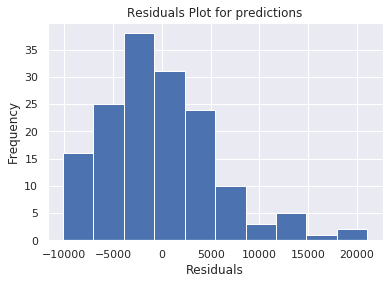

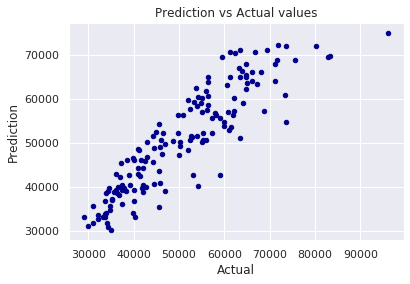

In [32]:
#Model 1 plotting graphs
model1_plot = HistogramPlotter(y_test1, model1.predict(sm.add_constant(X_test1)))
model1_scatter = ScatterPlotter(y_test1, model1.predict(sm.add_constant(X_test1)))

# Mode1 Histogram Plot
model1_plot.plot()

#model1 Scatter Plot
model1_scatter.plot()



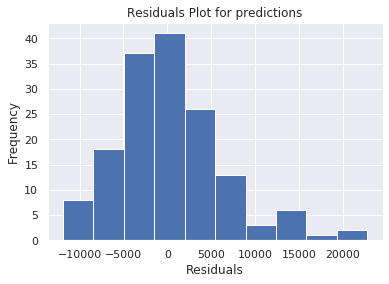

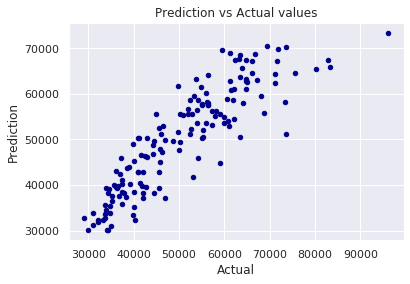

In [33]:
#Model 2 plotting graphs
model2_plot = HistogramPlotter(y_test2, model2.predict(sm.add_constant(X_test2)))
model2_scatter = ScatterPlotter(y_test2, model2.predict(sm.add_constant(X_test2)))

# Mode1 Histogram Plot
model2_plot.plot()

#model1 Scatter Plot
model2_scatter.plot()